Sahil's Code Goes Here:
Returns:
1. Spacing Parameter
2. Treble Stave Coordinate
3. Base Stave Coordinate

In [110]:
import numpy as np
from matplotlib import pyplot as plt
import os
from PIL import Image
import math
import cv2
from collections import Counter
image_path = '/content/drive/MyDrive/CVAssignment1/images_and_sample-code/test-images/music1.png'
from PIL import ImageFont, ImageDraw

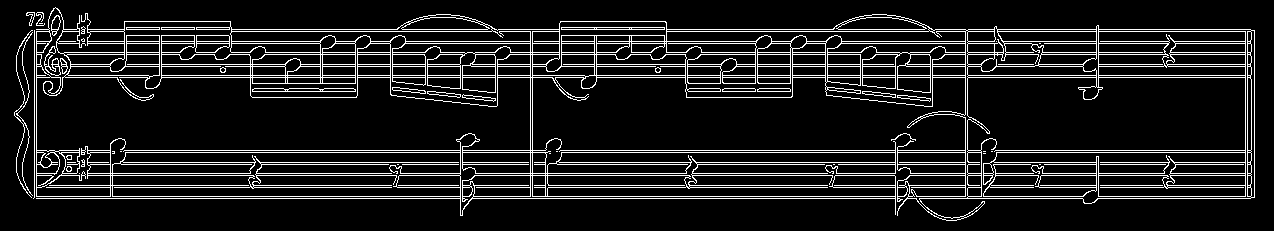

In [111]:
imgg = Image.open(image_path,mode='r').convert('L')
img_matrix = np.array(Image.open(image_path,mode='r').convert('L'))
res = cv2.Canny(img_matrix,threshold1 = 255, threshold2 = 255/3)
note_image = Image.fromarray(res).convert('L')
note_image

In [112]:
def get_coordinates_spacing(image_path):
  img_matrix = np.array(Image.open(image_path,mode='r').convert('L'))
  res = cv2.Canny(img_matrix,threshold1 = 255, threshold2 = 255/3)
  note_image = Image.fromarray(res).convert('L')
  image_arr = np.array(note_image)
  lst = []
  for i in range(image_arr.shape[0]):
    numbers = [image_arr[i,j] for j in range(image_arr.shape[1])]
    lst.append((i,np.round(np.mean(numbers),2)))

  lst1= [t for t in lst if t[1]>81 ]
  lst1.sort(key=lambda x:x[0],reverse=False)
  treble_stave= lst1[0][0]
  indx = [lst1[k][0] for k in range(len(lst1))]
  sub =  np.diff(indx)
  condition = sub > 4
  condition = np.insert(condition,0,True)
  final_indxs = []
  for m in range(len(indx)):
    if condition[m] == True:
      final_indxs.append(m)
  
  lst3 = [lst1[i] for i in final_indxs]
  indexes = [element[0] for element in lst3]
  sub =  np.diff(indexes)
  mask = np.logical_and(sub > 4, sub < 40)
  sub = sub[mask]
  c = Counter(sub)
  spacing_parameter = c.most_common(2)[0][0]
  
  print(f'{len(indexes)/5} sets of stave lines with mode spacing parameter:{spacing_parameter}')
  return(indexes,spacing_parameter)

In [113]:
indexes, spacing_parameter = get_coordinates_spacing(image_path)

2.0 sets of stave lines with mode spacing parameter:12


In [114]:
indexes

[29, 41, 52, 64, 75, 150, 162, 173, 185, 196]

Rescaling the templates for the image

In [115]:
image_path = image_path
template1_path = '/content/drive/MyDrive/CVAssignment1/images_and_sample-code/test-images/template1.png'
template2_path = '/content/drive/MyDrive/CVAssignment1/images_and_sample-code/test-images/template2.png'
template3_path = '/content/drive/MyDrive/CVAssignment1/images_and_sample-code/test-images/template3.png'

im = Image.open(image_path,mode='r').convert('L')
temp1 = Image.open(template1_path,mode="r").convert('L')
temp2 = Image.open(template2_path,mode="r").convert('L')
temp3 = Image.open(template3_path,mode="r").convert('L')

im_array = np.array(im)
temp_array1 = np.array(temp1)
temp_array2 = np.array(temp2)
temp_array3 = np.array(temp3)

height1 = temp_array1.shape[0]
width1 = temp_array1.shape[1]
new_height1 = spacing_parameter

#maintain aspect ratio
new_width1  = int(new_height1 * (width1 / height1))
#Resizing temp1 image
temp1=temp1.resize((new_width1,new_height1))
temp_array1 = np.array(temp1)


# scaling template from spacing parameter
# for template2
height2 = temp_array2.shape[0]
width2 = temp_array2.shape[1]
new_height2 = int(3*spacing_parameter)
new_width2  = int(new_height2 * (width2 / height2))
temp2 = temp2.resize((new_width2,new_height2))
temp_array2 = np.array(temp2)

# scaling template from spacing parameter
# for template3
height3 = temp_array3.shape[0]
width3 = temp_array3.shape[1]

new_height3 = int(2.5*spacing_parameter)
new_width3  = int(new_height3 * (width3 / height3))
temp3 = temp3.resize((new_width3,new_height3))
temp_array3 = np.array(temp3)

**Hamming Distance Template Matching**

In [116]:
import numpy as np
from PIL import Image, ImageDraw, ImageFilter
import math
import sklearn
from sklearn.preprocessing import minmax_scale

def Hamming_Distance(image_scaled,template_scaled):
  #Padding the image to take care of boundaries 
  
  image_padded = np.zeros(shape=(image_scaled.shape[0] + template_scaled.shape[0] - 1, image_scaled.shape[1] + template_scaled.shape[1] -1))
  image_padded[:image_scaled.shape[0], :image_scaled.shape[1]] = image_scaled

  #Calculating Hamming distance now for template matching
  f_ij = np.zeros((image_scaled.shape[0],image_scaled.shape[1]))
  for i in range(image_scaled.shape[0]):
    for j in range(image_scaled.shape[1]):
      patch = image_padded[i:template_scaled.shape[0]+i,j:template_scaled.shape[1]+j]
      #Applying the formula given in the assignment
      f_ij[i,j] = np.sum(np.multiply(patch,template_scaled)) + np.sum(np.multiply((1-patch),(1-template_scaled)))

  f_ij_scaled = 255*(f_ij - f_ij.min())/(f_ij.max() - f_ij.min())      
  f_ij_scaled = f_ij_scaled.astype(np.uint8)
  return(f_ij_scaled)

def template_matching(img_path,template_cutoff):
  #template_paths = [i[0] for i in template_cutoff]
  cutoffs = [i[1] for i in template_cutoff]
  image_scaled = minmax_scale(np.array(Image.open(img_path,mode="r").convert('L')))
  templates_scaled = [minmax_scale(template_cutoff[i][0]) for i in range(len(template_cutoff))]

  f_ijs = [Hamming_Distance(image_scaled,templates_scaled[i]) for i in range(len(templates_scaled))]

  images = [Image.fromarray(np.where(f_ijs[i] > cutoffs[i],255,0).astype(np.uint8))  for i in range(len(f_ijs))]
  
  return(images)

In [117]:
if image_path == '/content/drive/MyDrive/CVAssignment1/images_and_sample-code/test-images/music1.png':
  music_cutoffs = [220,250,245]
elif image_path == '/content/drive/MyDrive/CVAssignment1/images_and_sample-code/test-images/music2.png':
  music_cutoffs = [230,254,237]
elif image_path == '/content/drive/MyDrive/CVAssignment1/images_and_sample-code/test-images/music3.png':
  music_cutoffs = [220,253,252]
elif image_path == '/content/drive/MyDrive/CVAssignment1/images_and_sample-code/test-images/music4.png':
  music_cutoffs = [220,253,220]


In [118]:
template_cutoff = [(temp_array1,music_cutoffs[0]),(temp_array2,music_cutoffs[1]),(temp_array3,music_cutoffs[2])]
images = template_matching(image_path,template_cutoff)

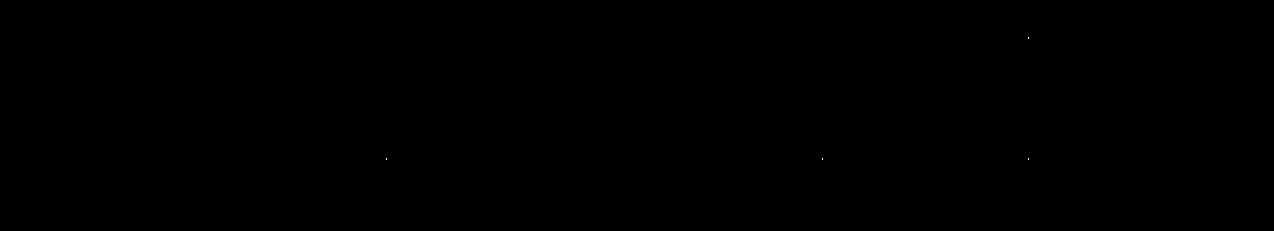

In [119]:
images[2]

**Note Annotation**

In [120]:
treble_notes = ['F','D','B','G','E']
middle_treble_notes = ['E','C','A','F']
base_notes = ['A','F','D','B','G']
middle_base_notes = ['G','E','C','A']  

In [121]:
combine_treble_base_notes = treble_notes+base_notes
combine_treble_base_notes

['F', 'D', 'B', 'G', 'E', 'A', 'F', 'D', 'B', 'G']

In [122]:
list_notes = []

for indx in enumerate(indexes):
  if indx[0]<10:
    list_notes.append((indx[1],combine_treble_base_notes[indx[0]]))
  elif indx[0] >=10 and indx[0]<20:
    list_notes.append((indx[1],combine_treble_base_notes[indx[0] % 10]))
  
  elif indx[0] >=20 and indx[0]<30:
    list_notes.append((indx[1],combine_treble_base_notes[indx[0] % 10]))
  
  elif indx[0] >=30 and indx[0]<40:
    list_notes.append((indx[1],combine_treble_base_notes[indx[0] % 10]))
  
  elif indx[0] >=40 and indx[0]<50:
    list_notes.append((indx[1],combine_treble_base_notes[indx[0] % 10]))
  
  elif indx[0] >=50 and indx[0]<60:
    list_notes.append((indx[1],combine_treble_base_notes[indx[0] % 10]))
  

list_notes

[(29, 'F'),
 (41, 'D'),
 (52, 'B'),
 (64, 'G'),
 (75, 'E'),
 (150, 'A'),
 (162, 'F'),
 (173, 'D'),
 (185, 'B'),
 (196, 'G')]

In [123]:
list_coordinates = [a_tuple[0] for a_tuple in list_notes]
print(list_coordinates)

[29, 41, 52, 64, 75, 150, 162, 173, 185, 196]


In [124]:
treble_note_f = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==0]
treble_note_d = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==1]
treble_note_b = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==2]
treble_note_g = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==3]
treble_note_e = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==4]
base_note_a = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==5]
base_note_f = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==6]
base_note_d = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==7]
base_note_b = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==8]
base_note_g = [k[1][0] for k in enumerate(list_notes) if k[0] % 10 ==9]

Non Maximal suppression to remove repeated bounding boxes

In [125]:
def non_max_suppression(boxes, overlap_threshold):
    selected_boxes = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = (x2 - x1) * (y2 - y1)
    sort_indexes = np.argsort(x1)

    while len(sort_indexes) > 0:
        last = len(sort_indexes) - 1
        last_box = sort_indexes[last]
        selected_boxes.append(last_box)
        suppressed_boxes = [last]
 
        for i in range(0, last):
            current_box = sort_indexes[i]
 
            max_x1 = max(x1[last_box], x1[current_box])
            max_y1 = max(y1[last_box], y1[current_box])
            min_x2 = min(x2[last_box], x2[current_box])
            min_y2 = min(y2[last_box], y2[current_box])
 
            compact_box_area = float(max(0, min_x2 - max_x1)*max(0, min_y2 - max_y1))
            overlap_perc = compact_box_area/area[current_box]
            if overlap_perc > overlap_threshold:
                suppressed_boxes.append(i)

        sort_indexes = np.delete(sort_indexes, suppressed_boxes)
 
    return boxes[selected_boxes]

In [127]:
def return_notes(k):
  
  for note in enumerate(treble_note_f):
    if k >= treble_note_f[note[0]] - (spacing_parameter/2) -3 and k <treble_note_f[note[0]]-1:
      text = 'F'
      return(text)
    elif k >= treble_note_f[note[0]]-(spacing_parameter*2)-1 and k <= treble_note_f[note[0]]-(spacing_parameter/2)-3:
      text = ''
      return(text)

  for note in enumerate(treble_note_d):
    if k >= treble_note_d[note[0]] - (spacing_parameter/2) -3 and k <treble_note_d[note[0]]-1:
      text = 'D'
      return(text)
    elif k >= treble_note_d[note[0]]-(spacing_parameter*2)-1 and k <= treble_note_d[note[0]]-(spacing_parameter/2)-3:
      text = 'E'
      return(text)


  for note in enumerate(treble_note_b):
    if k >= treble_note_b[note[0]] - (spacing_parameter/2) -3 and k <treble_note_b[note[0]]-1:
      text = 'B'
      return(text)
    elif k >= treble_note_b[note[0]]-(spacing_parameter*2)-1 and k <= treble_note_b[note[0]]-(spacing_parameter/2)-3:
      text = 'C'
      return(text)

  for note in enumerate(treble_note_g):
    if k >= treble_note_g[note[0]] - (spacing_parameter/2) -3 and k <treble_note_g[note[0]]-1:
      text = 'G'
      return(text)
    elif k >= treble_note_g[note[0]]-(spacing_parameter*2)-1 and k <= treble_note_g[note[0]]-(spacing_parameter/2)-3:
      text = 'A'
      return(text)
    

  for note in enumerate(treble_note_e):
    if k >= treble_note_e[note[0]] - (spacing_parameter/2) -3 and k <treble_note_e[note[0]]-1:
      text = 'E'
      return(text)
    elif k >= treble_note_e[note[0]]-(spacing_parameter*2)-1 and k <= treble_note_e[note[0]]-(spacing_parameter/2)-3:
      text = 'F'
      return(text)
    elif k >= treble_note_e[note[0]]-2 and k <= treble_note_e[note[0]]+5:
      text = 'D'
      return(text)
    elif k >= treble_note_e[note[0]] + 6 and k <= treble_note_e[note[0]]+30:
      text = 'B'
      return(text)

  for note in enumerate(base_note_a):
    if k < base_note_a[note[0]]-13 and k >= base_note_a[note[0]] - 30:
      text = 'C'
      return(text)
    
    elif k >= base_note_a[note[0]]-12 and k <= base_note_a[note[0]]-5:
      text = 'B'
      return(text)
    
    elif k >= base_note_a[note[0]] - (spacing_parameter/2) -3 and k <base_note_a[note[0]]-1:
      text = 'A'
      return(text)

  for note in enumerate(base_note_f):
    if k >= base_note_f[note[0]] - (spacing_parameter/2) -3 and k <base_note_f[note[0]]-1:
      text = 'F'
      return(text)
    elif k >= base_note_f[note[0]]-(spacing_parameter*2)-1 and k <= base_note_f[note[0]]-(spacing_parameter/2)-3:
      text = 'G'
      return(text)
  
  for note in enumerate(base_note_d):
    if k >= base_note_d[note[0]] - (spacing_parameter/2) -3 and k <base_note_d[note[0]]-1:
      text = 'D'
      return(text)
    elif k >= base_note_d[note[0]]-(spacing_parameter*2)-1 and k <= base_note_d[note[0]]-(spacing_parameter/2)-3:
      text = 'E'
      return(text)
  
  for note in enumerate(base_note_b):
    if k >= base_note_b[note[0]] - (spacing_parameter/2) -3 and k <base_note_b[note[0]]-1:
      text = 'B'
      return(text)
    elif k >= base_note_b[note[0]]-(spacing_parameter*2)-1 and k <= base_note_b[note[0]]-(spacing_parameter/2)-3:
      text = 'C'
      return(text)

  for note in enumerate(base_note_g):
    if k >= base_note_g[note[0]] - (spacing_parameter/2) -3 and k <base_note_g[note[0]]-1:
      text = 'G'
      return(text)
    elif k >= base_note_g[note[0]]-(spacing_parameter*2)-1 and k <= base_note_g[note[0]]-(spacing_parameter/2)-3:
      text = 'A'
      return(text)

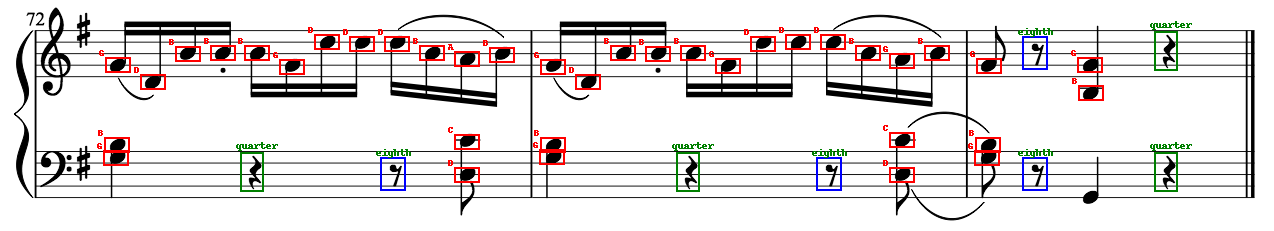

In [128]:
colors = ['red','green','blue']
convert_image = Image.open(image_path).convert('L')
im1 = convert_image.convert('RGB')
draw = ImageDraw.Draw(im1)
colors = ['red','green','blue']
coordinates = [(0,0)]
for k in range(len(images)):
  #path = template_cutoff[k][0]
  temp_array_1 = template_cutoff[k][0]
  #temp_array_1 = np.array(Image.open(path,mode="r").convert('L'))
  temp = np.array(images[k])
  box_endpoints = []
  for i in range(0,temp.shape[0]-40):
    for j in range(20,temp.shape[1]-30):
      if temp[i,j] == 255:
          x = i
          y = j
          x2 = x + temp_array_1.shape[0]
          y2 = y + temp_array_1.shape[1]
          box_endpoints.append([y,x,y2,x2])
          

  boxes_out = non_max_suppression(boxes=np.array(box_endpoints), overlap_threshold=0.3)
  for box in boxes_out:
    if box[0] >65  and box[1]>10 :
      draw.rectangle(((box[0]-6,box[1]-2),(box[2]+1,box[3]+1)), outline= colors[k] ,width=2) 
      text = return_notes(box[1])
      if text == None:
        text = ''
      else:
        text = text
      
      if k ==0:
        draw.text((box[0]-12,box[1]-12), text, fill='red',font = font)
      elif k ==1:
        draw.text((box[0]-10,box[1]-14), 'quarter', fill='green',font = font)
      elif k ==2:
        draw.text((box[0]-10,box[1]-12), 'eighth', fill='green',font = font)
im1